# Решение СЛАУ

In [104]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from math import *
import sympy

## Входные данные


<div>
<img src="system.png" width="600"/>
</div>

In [105]:
def cell(i, j):
    if i == j:
        return 10
    elif j > (i + 1):
        return 0
    else:
        return 1 / (i + 1)
    
def fv(i):
    return i + 1

n = 100

In [106]:
matrix = np.fromfunction(np.vectorize(cell, otypes=[float]), (n, n), dtype=float)
matrix

array([[10.        ,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5       , 10.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33333333,  0.33333333, 10.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.01020408,  0.01020408,  0.01020408, ..., 10.        ,
         0.01020408,  0.        ],
       [ 0.01010101,  0.01010101,  0.01010101, ...,  0.01010101,
        10.        ,  0.01010101],
       [ 0.01      ,  0.01      ,  0.01      , ...,  0.01      ,
         0.01      , 10.        ]])

In [107]:
f = np.fromfunction(np.vectorize(fv, otypes=[float]), (n,), dtype=float)
f

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

## Прямые методы

### Определим норму и $\varepsilon$ для прямых методов

In [108]:
epsilon = 1e-6

# "Кубическая" халявная норма вектора :)
def norm(x):
    return np.max(abs(x))

### Метод Гаусса с выбором главного элемента

In [109]:
def gauss(matrix, f):

    # Соберем всё в одну матрицу M = [A|f]
    M = np.hstack((matrix, f.reshape(-1, 1)))   

    # Прямой ход
    for i in range(len(matrix)):

        # Главный элемент отправляется на соответствующую строку
        pivot = np.argmax(np.abs(matrix[:,i]))
        M[[i, pivot]] = M[[pivot, i]] 

        div = M[i][i]

        # "Нормируем" строку
        row = M[i]
        row /= div

        # Зануляем всю колонку под нами
        for down in M[i + 1:]:
            down -= down[i] * row

    # Обратный ход
    for i in range(len(matrix) - 1, 0, -1):
        row = M[i]
        for up in reversed(M[:i]):
            up -= up[i] * row

    # Получена матрица вида M = [E|x]. Вытаскиваем x
    return M[:,-1]

In [110]:
# TODO: Проверить условие диагонального преобладания
x = gauss(matrix, f)

diff = np.matmul(matrix, x.T) - f
assert norm(diff) < epsilon

### LU-разложение

In [111]:
def decompose(A):
    U = A.copy()
    L = np.eye(n, dtype=np.double)
    
    for i in range(len(A)):
        
        # Чистим столбец от диагонали вниз.
        # Затем делаем обратное преобразование. Awesome!
        factor = U[i+1:, i] / U[i, i]
        L[i+1:, i] = factor
        U[i+1:] -= factor.reshape(-1, 1) * U[i]
       
    # TODO: Это не норма для матриц, но это assert-ы гыы :)
    assert (U - np.triu(U)).max() < epsilon
    assert (L - np.tril(L)).max() < epsilon
    assert (np.matmul(L, U) - matrix).max() < epsilon
    
    return L, U

def lu(matrix, f):        
    L, U = decompose(matrix)

    # Система Lv = f
    v = np.zeros(len(f))

    for i in range(len(f)):    
        v[i] = f[i] - np.matmul(L[i], v) 

    # Система Uu = v
    u = np.zeros(len(v))

    for i in range(len(v) - 1, -1, -1):    
        u[i] = (v[i] - np.matmul(U[i], u)) / U[i][i]
    
    return u

In [112]:
# TODO: Можно проверить миноры
x = lu(matrix, f)

diff = np.matmul(matrix, x.T) - f
assert norm(diff) < epsilon

## Итерационные методы

In [113]:
# Метод простой итерации с вычислением невязки 
# (обозначения см. Петров Лобанов курс лекций)
def fpi(B, F, n_it, matrix, f):
    u = np.zeros(len(F))
    diffs = np.zeros(n_it)
    for i in range(n_it):
        u = np.matmul(B, u) + F
        diffs[i] = norm(f - np.matmul(matrix, u))
    return u, diffs

# LDU-разложение
def ldu(matrix):
    L = matrix - np.triu(matrix)
    D = np.triu(matrix) + np.tril(matrix) - matrix
    U = matrix - np.tril(matrix)
    # Здесь можно на точное равенство проверить
    assert abs(L + D + U - matrix).max() == 0
    return  L, D, U

### Метод Якоби

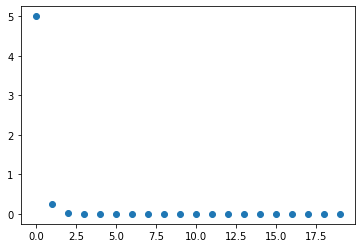

In [114]:
L, D, U = ldu(matrix)

B = -np.matmul(np.linalg.inv(D), (L + U))
F =  np.matmul(np.linalg.inv(D), f)

x, diffs = fpi(B, F, 20, matrix, f)
plt.scatter(range(len(diffs)), diffs)

## Метод Зейделя

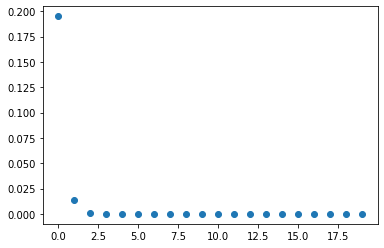

In [115]:
L, D, U = ldu(matrix)

B = -np.matmul(np.linalg.inv(L + D), U)
F =  np.matmul(np.linalg.inv(L + D), f)

x, diffs = fpi(B, F, 20, matrix, f)
plt.scatter(range(len(diffs)), diffs)

### Метод верхней релаксации

In [116]:
def sor(w):
    L, D, U = ldu(matrix)

    B = -np.matmul(np.linalg.inv(D + w * L), (w - 1) * D + w * L)
    F =  np.matmul(np.linalg.inv(D + w * L), f) * w

    x, diffs = fpi(B, F, 30, matrix, f)
    plt.scatter(range(len(diffs)), diffs)

#### Графики невязки от параметра релаксации ниже 

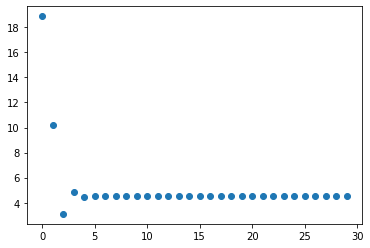

In [117]:
sor(w = 1.2)

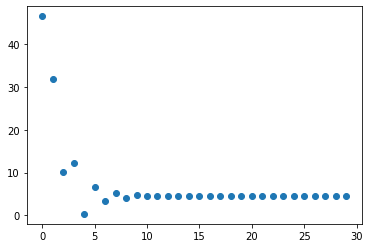

In [118]:
sor(w = 1.5)

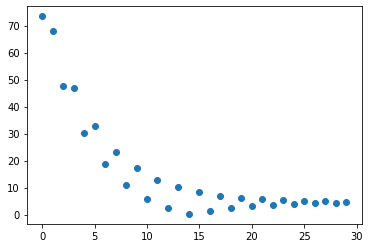

In [119]:
sor(w = 1.8)

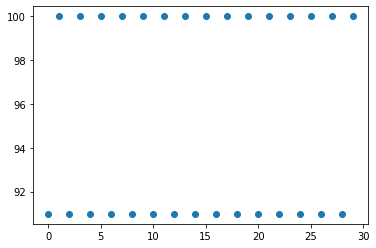

In [120]:
sor(w = 2)

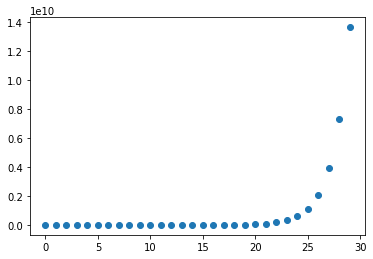

In [121]:
sor(w = 3)